<a href="https://colab.research.google.com/github/nakoyonioka/machine_learning/blob/main/nlp_research_articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/kaggle


In [2]:
%cd /content/gdrive/My Drive/kaggle/research_articles

/content/gdrive/My Drive/kaggle/research_articles


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=3c3bd188701d27b245b34ee98abc3d4247f54852e8bd39bdd3174fadc3585f64
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [ ]:
!kaggle datasets download -d vetrirah/janatahack-independence-day-2020-ml-hackathon

 44% 5.00M/11.4M [00:00<00:00, 40.2MB/s]
100% 11.4M/11.4M [00:00<00:00, 73.2MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  janatahack-independence-day-2020-ml-hackathon.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import numpy as np
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline

import nltk
from nltk.corpus import words as english_words, stopwords
import re

import pandas as pd

import wordcloud as Wordcloud
from collections import Counter
import seaborn as sns

import itertools

import spacy

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

In [ ]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [ ]:
train=train.dropna()

In [ ]:
train=train.reset_index(drop=True)

In [ ]:
train_id=train.pop('ID')

In [ ]:
train

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20967,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


In [ ]:
train.TITLE=train.TITLE+': '+train.ABSTRACT

In [ ]:
def bar_plot_distribution(topic):
  temp=train[topic].value_counts()
  sns.set_style("whitegrid")
  temp= temp.to_frame().reset_index().rename(columns={'index':topic,topic:'count'})
  plt.figure(figsize = (20,10)) 
  sns_bar=sns.barplot(x=topic,y="count", data = temp)
  sns_bar.set_xticklabels(labels=temp[topic], rotation=45)
  plt.title(f'Number of {topic} articles')
  sns.histplot(data=temp[topic].index)
  plt.show()

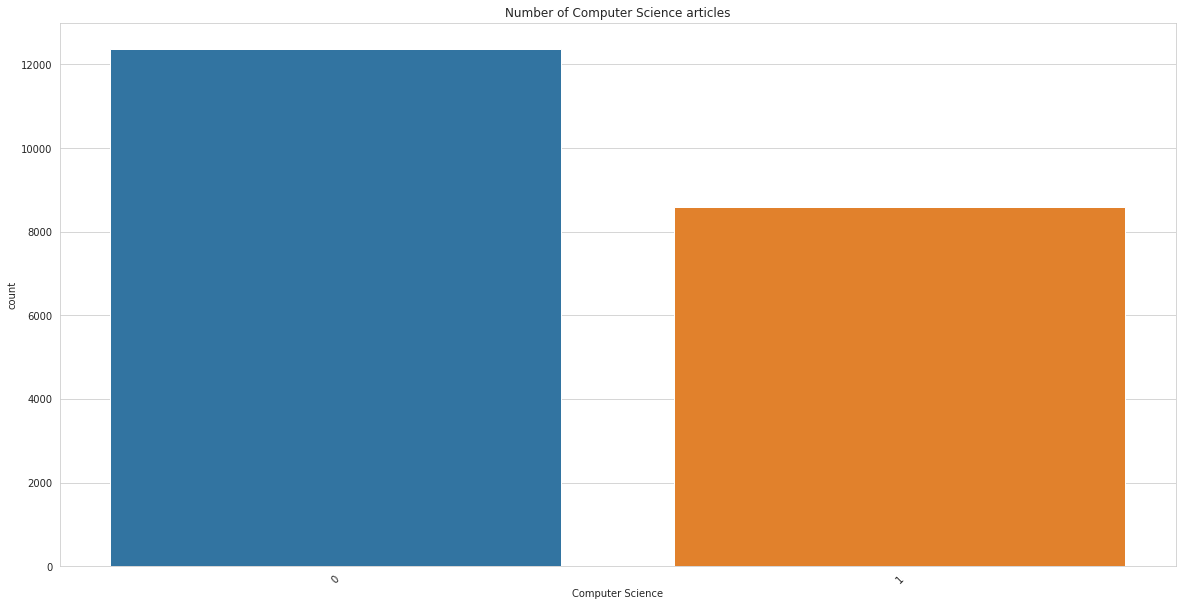

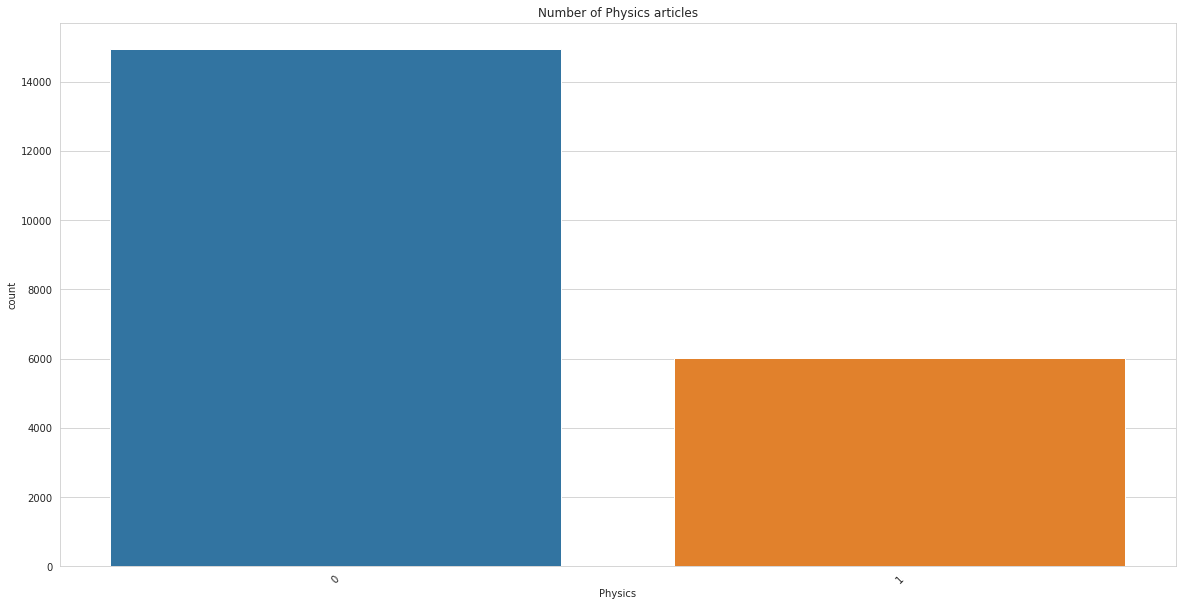

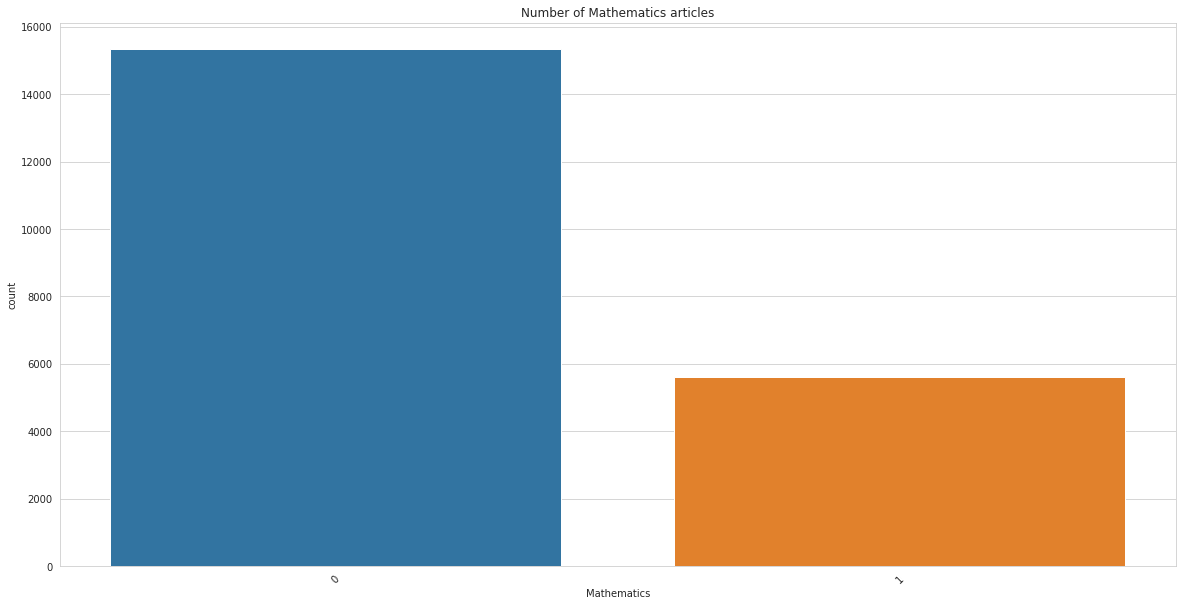

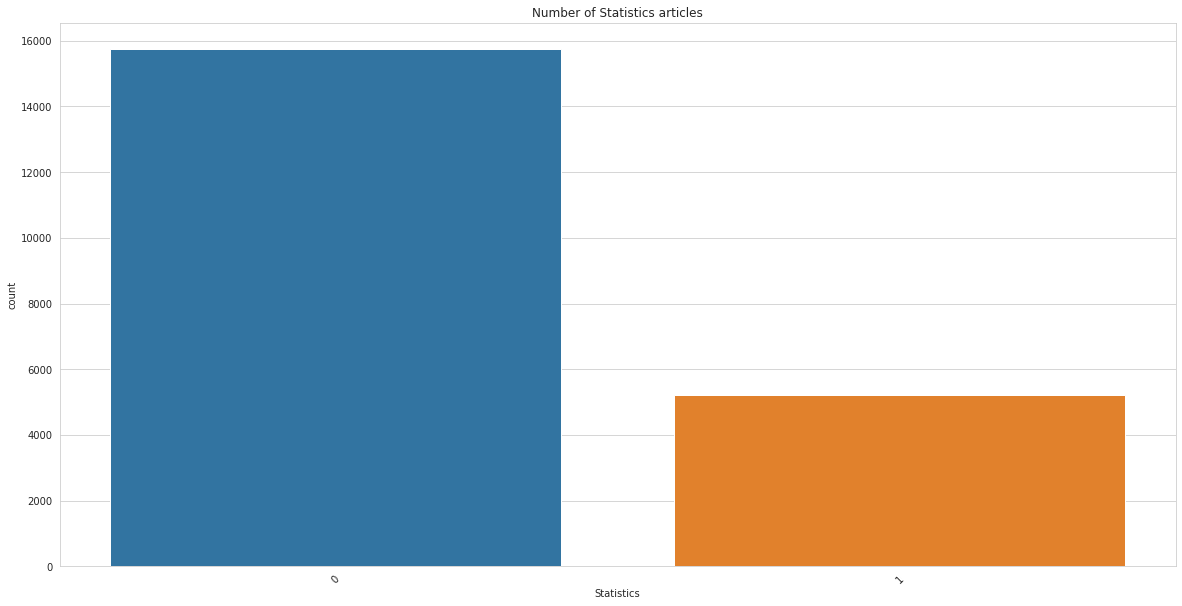

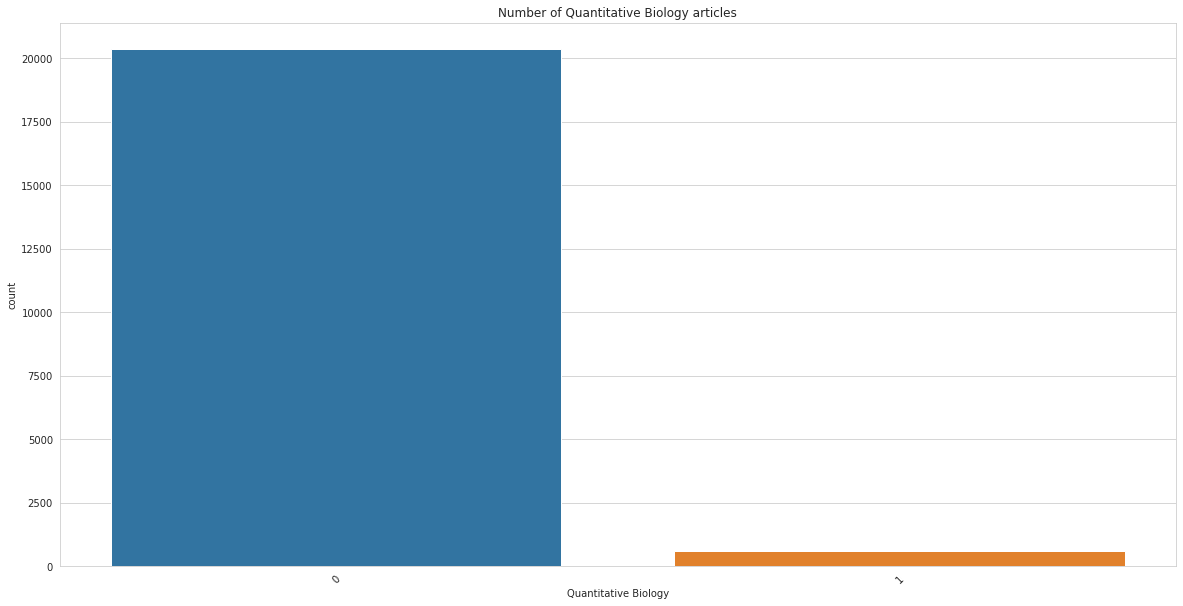

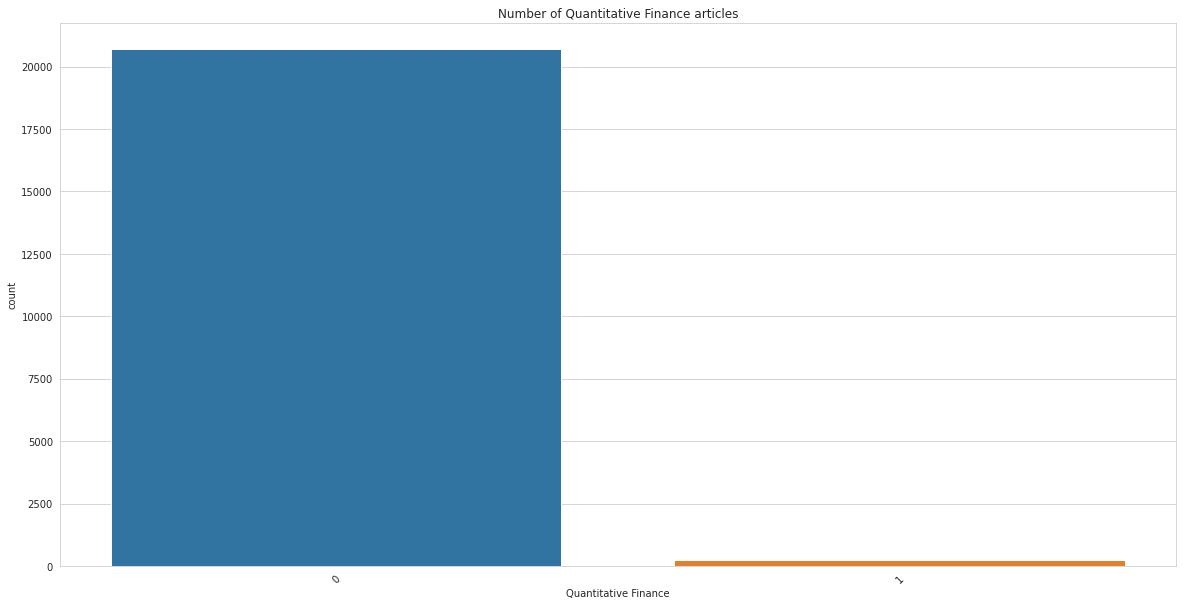

In [ ]:
bar_plot_distribution("Computer Science")
bar_plot_distribution("Physics")
bar_plot_distribution("Mathematics")
bar_plot_distribution("Statistics")
bar_plot_distribution("Quantitative Biology")
bar_plot_distribution("Quantitative Finance")

In [ ]:
train_abstract=train.pop('ABSTRACT')

In [ ]:
train['Computer Science']=train['Computer Science'].astype('str')
train['Physics']=train['Physics'].astype('str')
train['Mathematics']=train['Mathematics'].astype('str')
train['Statistics']=train['Statistics'].astype('str')
train['Quantitative Biology']=train['Quantitative Biology'].astype('str')
train['Quantitative Finance']=train['Quantitative Finance'].astype('str')

In [ ]:
train['label'] = train[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']].agg(''.join, axis=1)

In [ ]:
train.label=train.label.astype('str')

In [ ]:
def to_binary(x):
  return int(x, 2)

train.label=train.label.apply(lambda x:to_binary(x))

In [ ]:
train

,TITLE,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,label
0,Reconstructing Subject-Specific Effect Maps: ...,1,0,0,0,0,0,32
1,Rotation Invariance Neural Network: Rotation...,1,0,0,0,0,0,32
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0,8
3,A finite element approximation for the stochas...,0,0,1,0,0,0,8
4,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0,36
...,...,...,...,...,...,...,...,...
20967,Contemporary machine learning: a guide for pra...,1,1,0,0,0,0,48
20968,Uniform diamond coatings on WC-Co hard alloy c...,0,1,0,0,0,0,16
20969,Analysing Soccer Games with Clustering and Con...,1,0,0,0,0,0,32
20970,On the Efficient Simulation of the Left-Tail o...,0,0,1,1,0,0,12


#Preprocess data

In [ ]:
train['TITLE']=train['TITLE'].str.replace('\n',' ')

In [ ]:
#lower case
def lower(text):
    low_text= text.lower()
    return low_text
train['text']=train['TITLE'].apply(lambda x:lower(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train['text']=train['text'].apply(lambda x:remove_space(x))


In [ ]:
nlp=spacy.load('en')

def remove_stop_punct():
  tokens_all=[]
  for text in train['text']:
    my_doc = nlp(text)
    # Create list of word tokens
    spacy_tokens = [token.lemma_ for token in my_doc if token.is_stop != True and token.is_punct != True and token.is_alpha ==True]
    tokens_all.append(spacy_tokens)
  train['text']=tokens_all

remove_stop_punct()
train['text']=train['text'].str.join(',')

In [ ]:
train['text']=train['text'].str.replace(',', ' ')

In [ ]:
train.to_csv('./token_train.csv', index=False)

In [5]:
train=pd.read_csv('./token_train.csv')

In [6]:
train

,TITLE,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,label,text
0,Reconstructing Subject-Specific Effect Maps: ...,1,0,0,0,0,0,32,reconstruct subject specific effect map predic...
1,Rotation Invariance Neural Network: Rotation...,1,0,0,0,0,0,32,rotation invariance neural network rotation in...
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0,8,spherical polyharmonic poisson kernel polyharm...
3,A finite element approximation for the stochas...,0,0,1,0,0,0,8,finite element approximation stochastic maxwel...
4,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0,36,comparative study discrete wavelet transform w...
...,...,...,...,...,...,...,...,...,...
20967,Contemporary machine learning: a guide for pra...,1,1,0,0,0,0,48,contemporary machine learning guide practition...
20968,Uniform diamond coatings on WC-Co hard alloy c...,0,1,0,0,0,0,16,uniform diamond coating wc co hard alloy cut i...
20969,Analysing Soccer Games with Clustering and Con...,1,0,0,0,0,0,32,analyse soccer game clustering conceptor prese...
20970,On the Efficient Simulation of the Left-Tail o...,0,0,1,1,0,0,12,efficient simulation left tail sum correlate l...


#Example Text Classification

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=db3d25ea78df6c7166a20f34ae2f7984dd1d299477f258dc6540ac59b9386c27
  Stored in directory: /tmp/pip-ephem-wheel-cache-nz8feijf/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
X = train["text"].tolist()
y = train["Computer Science"].tolist()

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                    
                        stop_words='english')

# We transform each text into a vector
features = tfidf.fit_transform(X).toarray()

labels_CS_y = y

print("Each of the %d article entries is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)


In [ ]:
models = [
    LinearSVC(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels_CS_y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.849914,0.003926
RandomForestClassifier,0.682482,0.004410


In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels_CS_y, 
                                                               train.index, test_size=0.20, 
                                                               random_state=1)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Text Classification for binary encoded label with Spacy

In [ ]:
X_train, X_test, = train_test_split(train, test_size=0.33, random_state=42)

In [ ]:
text_train=X_train['text'].tolist()
text_test=X_test['text'].tolist()

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=1f6d1285a6e65f41e1e0183c564cce99e5c38799fd1a0c8420ffefd922af049b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7d0jfnwc/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

In [ ]:
docs_train=[nlp(text) for text in text_train]
docs_test=[nlp(text) for text in text_test]

In [ ]:
train_x_vectors=[x.vector for x in docs_train]
test_x_vectors=[x.vector for x in docs_test]

In [ ]:
y_train = X_train["label"].tolist()
y_test = X_test["label"].tolist()

In [ ]:
model_spacy = LinearSVC(verbose=1, max_iter=2000, C=10.0)
model_spacy.fit(train_x_vectors, y_train)

[LibLinear]

LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [ ]:
y_pred = model_spacy.predict(test_x_vectors)

In [ ]:
data = {'real': y_test, 'predicted': y_pred}
predicted = pd.DataFrame(data=data)

In [ ]:
from numpy import binary_repr

def dec_to_binary(x):
  return binary_repr(int(x), width=6)

predicted.real=predicted.real.apply(lambda x:dec_to_binary(x))
predicted.predicted=predicted.predicted.apply(lambda x:dec_to_binary(x))

In [ ]:
predicted.real=predicted.real.astype('str')
predicted.predicted=predicted.predicted.astype('str')

predicted.real=predicted.real.values.tolist()
predicted.predicted=predicted.predicted.values.tolist()

In [ ]:
predicted['cs']=np.zeros((predicted.shape[0]))
predicted['ph']=np.zeros((predicted.shape[0]))
predicted['mat']=np.zeros((predicted.shape[0]))
predicted['stat']=np.zeros((predicted.shape[0]))
predicted['qb']=np.zeros((predicted.shape[0]))
predicted['qf']=np.zeros((predicted.shape[0]))


predicted['cs_p']=np.zeros((predicted.shape[0]))
predicted['ph_p']=np.zeros((predicted.shape[0]))
predicted['mat_p']=np.zeros((predicted.shape[0]))
predicted['stat_p']=np.zeros((predicted.shape[0]))
predicted['qb_p']=np.zeros((predicted.shape[0]))
predicted['qf_p']=np.zeros((predicted.shape[0]))

In [ ]:
#CS, PH, MAT, STAT, QB, QF
i=0
for item in predicted.real:
  predicted['cs'][i]=item[0]
  predicted['ph'][i]=item[1]
  predicted['mat'][i]=item[2]
  predicted['stat'][i]=item[3]
  predicted['qb'][i]=item[4]
  predicted['qf'][i]=item[5]
  i=i+1

i=0
for item in predicted.predicted:
  predicted['cs_p'][i]=item[0]
  predicted['ph_p'][i]=item[1]
  predicted['mat_p'][i]=item[2]
  predicted['stat_p'][i]=item[3]
  predicted['qb_p'][i]=item[4]
  predicted['qf_p'][i]=item[5]
  i=i+1

In [ ]:
predicted['cs']=predicted['cs'].astype('int32')
predicted['ph']=predicted['ph'].astype('int32')
predicted['mat']=predicted['mat'].astype('int32')
predicted['stat']=predicted['stat'].astype('int32')
predicted['qb']=predicted['qb'].astype('int32')
predicted['qf']=predicted['qf'].astype('int32')


predicted['cs_p']=predicted['cs_p'].astype('int32')
predicted['ph_p']=predicted['ph_p'].astype('int32')
predicted['mat_p']=predicted['mat_p'].astype('int32')
predicted['stat_p']=predicted['stat_p'].astype('int32')
predicted['qb_p']=predicted['qb_p'].astype('int32')
predicted['qf_p']=predicted['qf_p'].astype('int32')

In [ ]:
predicted

,real,predicted,cs,ph,mat,stat,qb,qf,cs_p,ph_p,mat_p,stat_p,qb_p,qf_p
0,100000,100100,1,0,0,0,0,0,1,0,0,1,0,0
1,001100,001000,0,0,1,1,0,0,0,0,1,0,0,0
2,101000,100000,1,0,1,0,0,0,1,0,0,0,0,0
3,010100,001000,0,1,0,1,0,0,0,0,1,0,0,0
4,100000,100000,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916,000010,010000,0,0,0,0,1,0,0,1,0,0,0,0
6917,000100,001000,0,0,0,1,0,0,0,0,1,0,0,0
6918,001000,001000,0,0,1,0,0,0,0,0,1,0,0,0
6919,010000,010000,0,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
train['Computer Science Labels']=train['Computer Science'].astype('str')
train['Physics Labels']=train['Physics'].astype('str')
train['Mathematics Labels']=train['Mathematics'].astype('str')
train['Statistics Labels']=train['Statistics'].astype('str')
train['Quantitative Biology Labels']=train['Quantitative Biology'].astype('str')
train['Quantitative Finance Labels']=train['Quantitative Finance'].astype('str')

In [ ]:
for index in range(6):
  if index==0:
    print('\t\t\t\tCLASSIFICATIION METRICS CS\n')
    print(metrics.classification_report(predicted['cs'], predicted['cs_p'], 
                                      target_names= train['Computer Science Labels'].unique()))
  elif index==1:
    print('\t\t\t\tCLASSIFICATIION METRICS PH\n')
    print(metrics.classification_report(predicted['ph'], predicted['ph_p'], 
                                      target_names= train['Physics Labels'].unique()))
  elif index==2:
    print('\t\t\t\tCLASSIFICATIION METRICS MAT\n')
    print(metrics.classification_report(predicted['mat'], predicted['mat_p'],
                                      target_names= train['Mathematics Labels'].unique()))
  elif index==3:
    print('\t\t\t\tCLASSIFICATIION METRICS STAT\n')
    print(metrics.classification_report(predicted['stat'], predicted['stat_p'],
                                      target_names= train['Statistics Labels'].unique()))
  elif index==4:
    print('\t\t\t\tCLASSIFICATIION METRICS QB\n')
    print(metrics.classification_report(predicted['qb'], predicted['qb_p'],
                                      target_names= train['Quantitative Biology Labels'].unique()))
  elif index==5:
    print('\t\t\t\tCLASSIFICATIION METRICS QF\n')
    print(metrics.classification_report(predicted['qf'], predicted['qf_p'],
                                      target_names= train['Quantitative Finance Labels'].unique()))

				CLASSIFICATIION METRICS CS

              precision    recall  f1-score   support

           1       0.88      0.85      0.87      4122
           0       0.79      0.82      0.81      2799

    accuracy                           0.84      6921
   macro avg       0.84      0.84      0.84      6921
weighted avg       0.84      0.84      0.84      6921

				CLASSIFICATIION METRICS PH

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4879
           1       0.88      0.82      0.85      2042

    accuracy                           0.92      6921
   macro avg       0.91      0.89      0.90      6921
weighted avg       0.91      0.92      0.91      6921

				CLASSIFICATIION METRICS MAT

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5050
           1       0.82      0.74      0.78      1871

    accuracy                           0.89      6921
   macro avg       0.87      0.

In [ ]:
cs_id=train['Computer Science Labels'].drop_duplicates()
ph_id=train['Physics Labels'].drop_duplicates()
mat_id=train['Mathematics Labels'].drop_duplicates()
stat_id=train['Statistics Labels'].drop_duplicates()
qb_id=train['Quantitative Biology Labels'].drop_duplicates()
qf_id=train['Quantitative Finance Labels'].drop_duplicates()

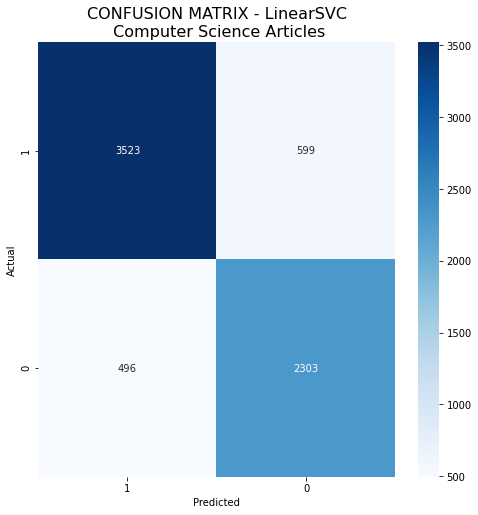

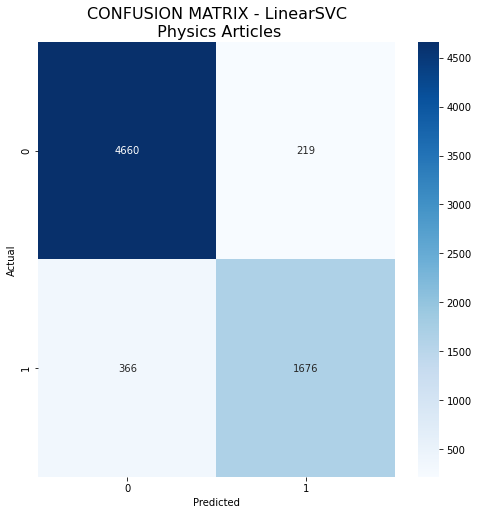

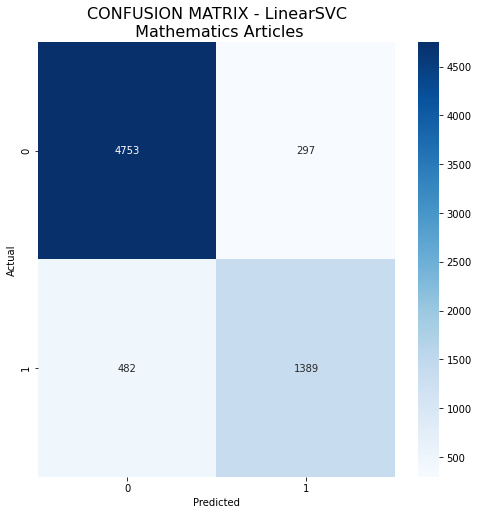

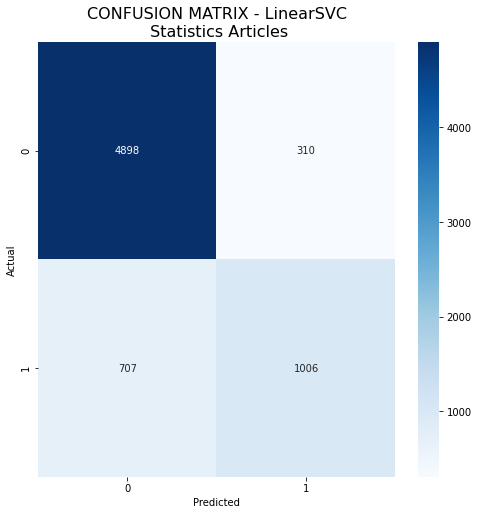

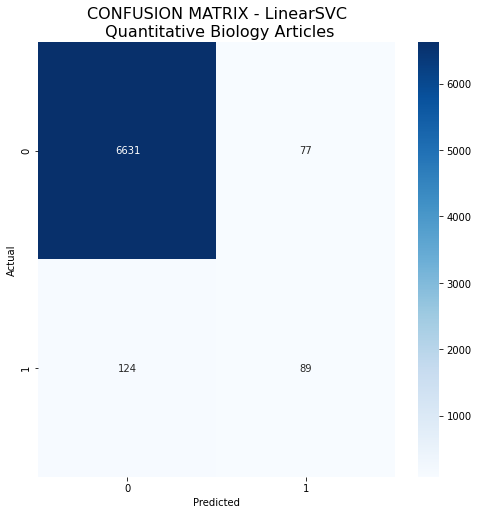

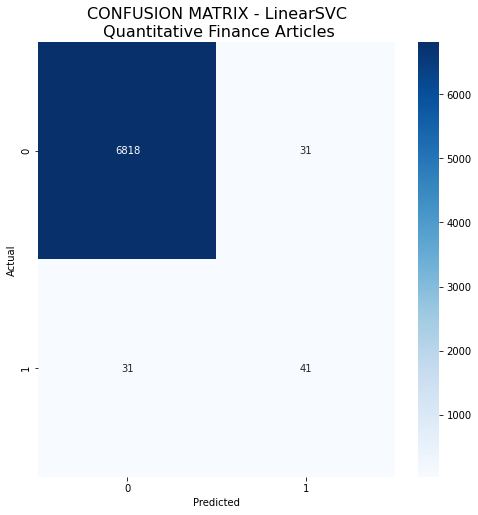

In [ ]:
conf_mat = confusion_matrix(predicted['cs'], predicted['cs_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=cs_id.values, 
            yticklabels=cs_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Computer Science Articles", size=16);

conf_mat = confusion_matrix(predicted['ph'], predicted['ph_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=ph_id.values, 
            yticklabels=ph_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Physics Articles", size=16);

conf_mat = confusion_matrix(predicted['mat'], predicted['mat_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=mat_id.values, 
            yticklabels=mat_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Mathematics Articles", size=16);

conf_mat = confusion_matrix(predicted['stat'], predicted['stat_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=stat_id.values, 
            yticklabels=stat_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Statistics Articles", size=16);

conf_mat = confusion_matrix(predicted['qb'], predicted['qb_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=qb_id.values, 
            yticklabels=qb_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Quantitative Biology Articles", size=16);

conf_mat = confusion_matrix(predicted['qf'], predicted['qf_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=qf_id.values, 
            yticklabels=qf_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Quantitative Finance Articles", size=16);

#Text Classification with BERT

In [ ]:
!pip install spacy-transformers==0.5.2

In [ ]:
!python -m spacy download en_trf_bertbaseuncased_lg

In [ ]:
!pip install --upgrade urllib3

In [8]:
X_train_b, X_test_b = train_test_split(train, test_size=0.33, random_state=42)

In [9]:
X_train_bert=X_train_b[0:int(len(X_train_b)/2)] #take half of train dataset
X_test_bert=X_test_b[0:int(len(X_test_b)/4)]

In [10]:
text_train=X_train_bert['TITLE'].tolist()
text_test=X_test_bert['TITLE'].tolist()

In [11]:
import spacy
import torch 

nlp = spacy.load("en_trf_bertbaseuncased_lg")

In [ ]:
#fix for bug in spacy transformers sentencizier
!pip install https://github.com/explosion/spacy-transformers/archive/v0.5.x.zip

In [ ]:
docs_train=[nlp(text) for text in text_train]

In [ ]:
docs_test=[nlp(text) for text in text_test]

In [ ]:
train_x_vectors=[x.vector for x in docs_train]
test_x_vectors=[x.vector for x in docs_test]

In [ ]:
y_train = X_train_bert["label"].tolist()
y_test_bert = X_test_bert["label"].tolist()

In [ ]:
model_bert = LinearSVC(verbose=1, C=10.0)
model_bert.fit(train_x_vectors, y_train)

In [ ]:
y_pred_bert = model_bert.predict(test_x_vectors)

In [ ]:
data = {'real': y_test_bert, 'predicted': y_pred_bert}
bert = pd.DataFrame(data=data)

In [ ]:
bert.to_csv('./bert.csv')

In [ ]:
from numpy import binary_repr

def dec_to_binary(x):
  return binary_repr(int(x), width=6)

bert.real=bert.real.apply(lambda x:dec_to_binary(x))
bert.predicted=bert.predicted.apply(lambda x:dec_to_binary(x))

In [ ]:
bert.real=bert.real.astype('str')
bert.predicted=bert.predicted.astype('str')

bert.real=bert.real.values.tolist()
bert.predicted=bert.predicted.values.tolist()

In [ ]:
bert['cs']=np.zeros((bert.shape[0]))
bert['ph']=np.zeros((bert.shape[0]))
bert['mat']=np.zeros((bert.shape[0]))
bert['stat']=np.zeros((bert.shape[0]))
bert['qb']=np.zeros((bert.shape[0]))
bert['qf']=np.zeros((bert.shape[0]))


bert['cs_p']=np.zeros((bert.shape[0]))
bert['ph_p']=np.zeros((bert.shape[0]))
bert['mat_p']=np.zeros((bert.shape[0]))
bert['stat_p']=np.zeros((bert.shape[0]))
bert['qb_p']=np.zeros((bert.shape[0]))
bert['qf_p']=np.zeros((bert.shape[0]))

In [ ]:
#CS, PH, MAT, STAT, QB, QF
i=0
for item in bert.real:
  bert['cs'][i]=item[0]
  bert['ph'][i]=item[1]
  bert['mat'][i]=item[2]
  bert['stat'][i]=item[3]
  bert['qb'][i]=item[4]
  bert['qf'][i]=item[5]
  i=i+1

i=0
for item in bert.predicted:
  bert['cs_p'][i]=item[0]
  bert['ph_p'][i]=item[1]
  bert['mat_p'][i]=item[2]
  bert['stat_p'][i]=item[3]
  bert['qb_p'][i]=item[4]
  bert['qf_p'][i]=item[5]
  i=i+1

In [ ]:
bert['cs']=bert['cs'].astype('int32')
bert['ph']=bert['ph'].astype('int32')
bert['mat']=bert['mat'].astype('int32')
bert['stat']=bert['stat'].astype('int32')
bert['qb']=bert['qb'].astype('int32')
bert['qf']=bert['qf'].astype('int32')


bert['cs_p']=bert['cs_p'].astype('int32')
bert['ph_p']=bert['ph_p'].astype('int32')
bert['mat_p']=bert['mat_p'].astype('int32')
bert['stat_p']=bert['stat_p'].astype('int32')
bert['qb_p']=bert['qb_p'].astype('int32')
bert['qf_p']=bert['qf_p'].astype('int32')

In [ ]:
train['Computer Science Labels']=train['Computer Science'].astype('str')
train['Physics Labels']=train['Physics'].astype('str')
train['Mathematics Labels']=train['Mathematics'].astype('str')
train['Statistics Labels']=train['Statistics'].astype('str')
train['Quantitative Biology Labels']=train['Quantitative Biology'].astype('str')
train['Quantitative Finance Labels']=train['Quantitative Finance'].astype('str')

In [ ]:
for index in range(6):
  if index==0:
    print('\t\t\t\tCLASSIFICATIION METRICS CS\n')
    print(metrics.classification_report(bert['cs'], bert['cs_p'], 
                                      target_names= train['Computer Science Labels'].unique()))
  elif index==1:
    print('\t\t\t\tCLASSIFICATIION METRICS PH\n')
    print(metrics.classification_report(bert['ph'], bert['ph_p'], 
                                      target_names= train['Physics Labels'].unique()))
  elif index==2:
    print('\t\t\t\tCLASSIFICATIION METRICS MAT\n')
    print(metrics.classification_report(bert['mat'], bert['mat_p'],
                                      target_names= train['Mathematics Labels'].unique()))
  elif index==3:
    print('\t\t\t\tCLASSIFICATIION METRICS STAT\n')
    print(metrics.classification_report(bert['stat'], bert['stat_p'],
                                      target_names= train['Statistics Labels'].unique()))
  elif index==4:
    print('\t\t\t\tCLASSIFICATIION METRICS QB\n')
    print(metrics.classification_report(bert['qb'], bert['qb_p'],
                                      target_names= train['Quantitative Biology Labels'].unique()))
  elif index==5:
    print('\t\t\t\tCLASSIFICATIION METRICS QF\n')
    print(metrics.classification_report(bert['qf'], bert['qf_p'],
                                      target_names= train['Quantitative Finance Labels'].unique()))

In [ ]:
cs_id=train['Computer Science Labels'].drop_duplicates()
ph_id=train['Physics Labels'].drop_duplicates()
mat_id=train['Mathematics Labels'].drop_duplicates()
stat_id=train['Statistics Labels'].drop_duplicates()
qb_id=train['Quantitative Biology Labels'].drop_duplicates()
qf_id=train['Quantitative Finance Labels'].drop_duplicates()

In [ ]:
conf_mat = confusion_matrix(bert['cs'], bert['cs_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=cs_id.values, 
            yticklabels=cs_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Computer Science Articles", size=16);

conf_mat = confusion_matrix(bert['ph'], bert['ph_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=ph_id.values, 
            yticklabels=ph_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Physics Articles", size=16);

conf_mat = confusion_matrix(bert['mat'], bert['mat_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=mat_id.values, 
            yticklabels=mat_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Mathematics Articles", size=16);

conf_mat = confusion_matrix(bert['stat'], bert['stat_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=stat_id.values, 
            yticklabels=stat_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Statistics Articles", size=16);

conf_mat = confusion_matrix(bert['qb'], bert['qb_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=qb_id.values, 
            yticklabels=qb_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Quantitative Biology Articles", size=16);

conf_mat = confusion_matrix(bert['qf'], bert['qf_p'],)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=qf_id.values, 
            yticklabels=qf_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Quantitative Finance Articles", size=16);

#Text Classification for all labels

In [ ]:
def tfid_vectorizer(label):
  X = train["text"].tolist()
  y = train[label].tolist()

  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')
  #We transform each text into a vector
  features = tfidf.fit_transform(X).toarray()
  labels = y

  print("Each of the %d article entries is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))
  return features, labels

In [ ]:
features,labels_CS=tfid_vectorizer('Computer Science')
features,labels_PH=tfid_vectorizer('Physics')
features,labels_MAT=tfid_vectorizer('Mathematics')
features,labels_STAT=tfid_vectorizer('Statistics')
features,labels_QB=tfid_vectorizer('Quantitative Biology')
features,labels_QF=tfid_vectorizer('Quantitative Finance')

Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)
Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)
Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)
Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)
Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)
Each of the 20972 article entries is represented by 11197 features (TF-IDF score of unigrams and bigrams)


In [ ]:
for index in range(6):
  if index==0:
    X_train, X_test, y_train, y_test_CS = train_test_split(features, labels_CS, test_size=0.20, random_state=1)
    model_CS =   LinearSVC()
    model_CS.fit(X_train, y_train)
    y_pred_CS = model_CS.predict(X_test)
  elif index==1:
    X_train, X_test, y_train, y_test_PH = train_test_split(features, labels_PH, test_size=0.20, random_state=1)
    model_PH =   LinearSVC()
    model_PH.fit(X_train, y_train)
    y_pred_PH = model_PH.predict(X_test)
  elif index==2:
    X_train, X_test, y_train, y_test_MAT = train_test_split(features, labels_MAT, test_size=0.20, random_state=1)
    model_MAT =   LinearSVC()
    model_MAT.fit(X_train, y_train)
    y_pred_MAT = model_MAT.predict(X_test)
  elif index==3:
    X_train, X_test, y_train, y_test_STAT = train_test_split(features, labels_STAT, test_size=0.20, random_state=1)
    model_STAT =   LinearSVC()
    model_STAT.fit(X_train, y_train)
    y_pred_STAT = model_STAT.predict(X_test)
  elif index==4:
    X_train, X_test, y_train, y_test_QB = train_test_split(features, labels_QB, test_size=0.20, random_state=1)
    model_QB =   LinearSVC()
    model_QB.fit(X_train, y_train)
    y_pred_QB = model_QB.predict(X_test)
  elif index==5:
    X_train, X_test, y_train, y_test_QF = train_test_split(features, labels_QF, test_size=0.20, random_state=1)
    model_QF =   LinearSVC()
    model_QF.fit(X_train, y_train)
    y_pred_QF = model_QF.predict(X_test)

In [ ]:
train['Computer Science Labels']=train['Computer Science'].astype('str')
train['Physics Labels']=train['Physics'].astype('str')
train['Mathematics Labels']=train['Mathematics'].astype('str')
train['Statistics Labels']=train['Statistics'].astype('str')
train['Quantitative Biology Labels']=train['Quantitative Biology'].astype('str')
train['Quantitative Finance Labels']=train['Quantitative Finance'].astype('str')

In [ ]:
for index in range(6):
  if index==0:
    print('\t\t\t\tCLASSIFICATIION METRICS CS\n')
    print(metrics.classification_report(y_test_CS, y_pred_CS, 
                                      target_names= train['Computer Science Labels'].unique()))
  elif index==1:
    print('\t\t\t\tCLASSIFICATIION METRICS PH\n')
    print(metrics.classification_report(y_test_PH, y_pred_PH, 
                                      target_names= train['Physics Labels'].unique()))
  elif index==2:
    print('\t\t\t\tCLASSIFICATIION METRICS MAT\n')
    print(metrics.classification_report(y_test_MAT, y_pred_MAT, 
                                      target_names= train['Mathematics Labels'].unique()))
  elif index==3:
    print('\t\t\t\tCLASSIFICATIION METRICS STAT\n')
    print(metrics.classification_report(y_test_STAT, y_pred_STAT, 
                                      target_names= train['Statistics Labels'].unique()))
  elif index==4:
    print('\t\t\t\tCLASSIFICATIION METRICS QB\n')
    print(metrics.classification_report(y_test_QB, y_pred_QB, 
                                      target_names= train['Quantitative Biology Labels'].unique()))
  elif index==5:
    print('\t\t\t\tCLASSIFICATIION METRICS QF\n')
    print(metrics.classification_report(y_test_QF, y_pred_QF, 
                                      target_names= train['Quantitative Finance Labels'].unique()))

				CLASSIFICATIION METRICS CS

              precision    recall  f1-score   support

           1       0.88      0.87      0.88      2502
           0       0.81      0.83      0.82      1693

    accuracy                           0.85      4195
   macro avg       0.85      0.85      0.85      4195
weighted avg       0.85      0.85      0.85      4195

				CLASSIFICATIION METRICS PH

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2986
           1       0.91      0.84      0.88      1209

    accuracy                           0.93      4195
   macro avg       0.92      0.91      0.91      4195
weighted avg       0.93      0.93      0.93      4195

				CLASSIFICATIION METRICS MAT

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3067
           1       0.84      0.78      0.81      1128

    accuracy                           0.90      4195
   macro avg       0.88      0.

In [ ]:
cs_id=train['Computer Science Labels'].drop_duplicates()
ph_id=train['Physics Labels'].drop_duplicates()
mat_id=train['Mathematics Labels'].drop_duplicates()
stat_id=train['Statistics Labels'].drop_duplicates()
qb_id=train['Quantitative Biology Labels'].drop_duplicates()
qf_id=train['Quantitative Finance Labels'].drop_duplicates()

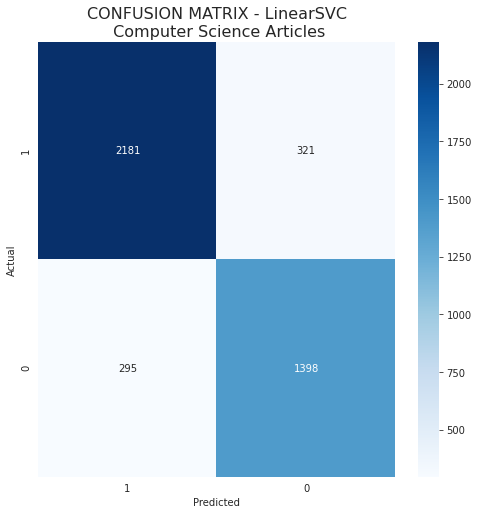

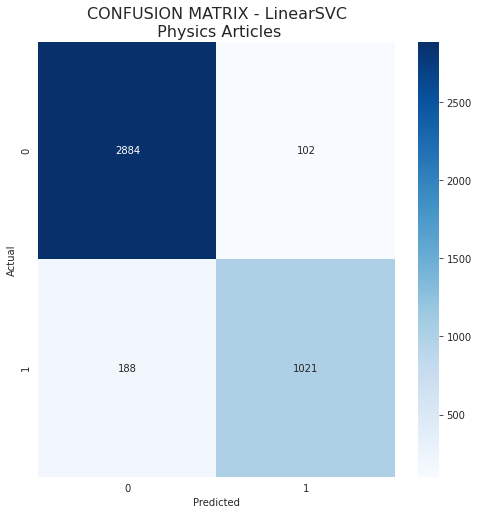

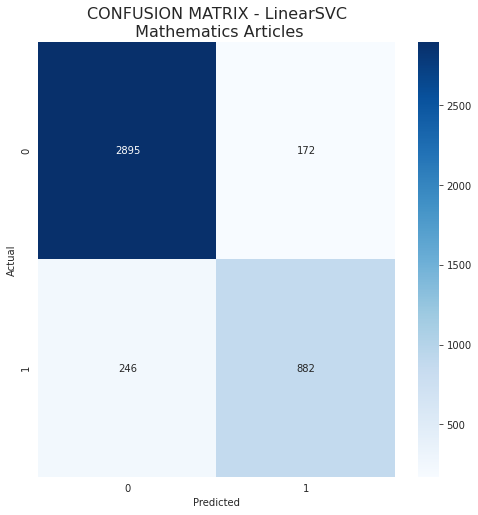

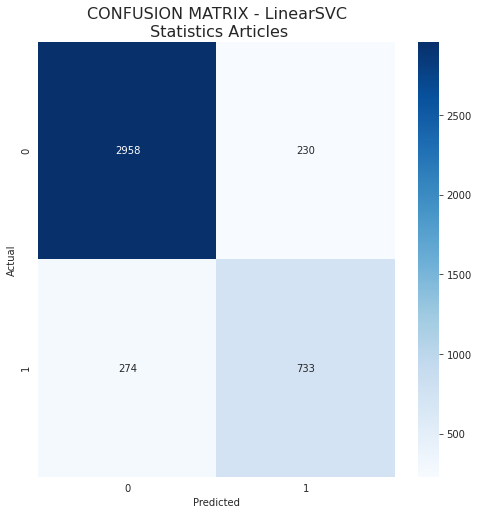

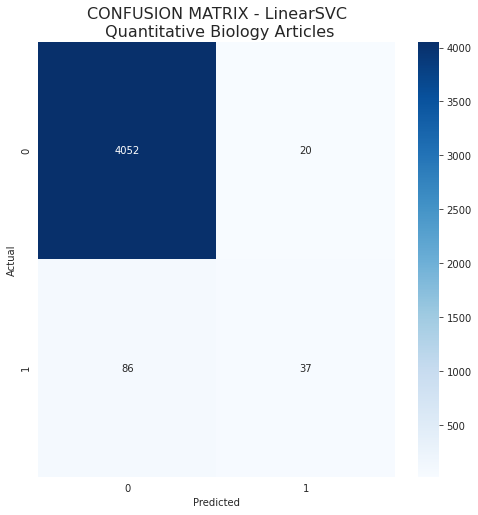

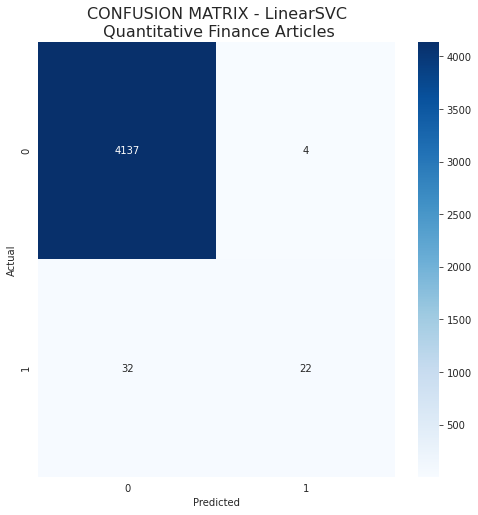

In [ ]:
conf_mat = confusion_matrix(y_test_CS, y_pred_CS)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=cs_id.values, 
            yticklabels=cs_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Computer Science Articles", size=16);

conf_mat = confusion_matrix(y_test_PH, y_pred_PH)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=ph_id.values, 
            yticklabels=ph_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Physics Articles", size=16);

conf_mat = confusion_matrix(y_test_MAT, y_pred_MAT)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=mat_id.values, 
            yticklabels=mat_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Mathematics Articles", size=16);

conf_mat = confusion_matrix(y_test_STAT, y_pred_STAT)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=stat_id.values, 
            yticklabels=stat_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Statistics Articles", size=16);

conf_mat = confusion_matrix(y_test_QB, y_pred_QB)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=qb_id.values, 
            yticklabels=qb_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Quantitative Biology Articles", size=16);

conf_mat = confusion_matrix(y_test_QF, y_pred_QF)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=qf_id.values, 
            yticklabels=qf_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n Quantitative Finance Articles", size=16);

#Predict classification of test data

In [ ]:
test['text']=test.TITLE+test.ABSTRACT

In [ ]:
#lower case
def lower(text):
    low_text= text.lower()
    return low_text
test['text']=test['text'].apply(lambda x:lower(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
test['text']=test['text'].apply(lambda x:remove_space(x))

In [ ]:
def remove_stop_punct():
  tokens_all=[]
  for text in test['text']:
    my_doc = nlp(text)
    # Create list of word tokens
    spacy_tokens = [token.lemma_ for token in my_doc if token.is_stop != True and token.is_punct != True and token.is_alpha ==True]
    tokens_all.append(spacy_tokens)
  test['text']=tokens_all

remove_stop_punct()
test['text']=test['text'].str.join(',')

In [ ]:
test['text']=test['text'].str.replace(',', ' ')

In [ ]:
test.to_csv('./token_test.csv')

In [ ]:
def tfid_vectorizer_pred():
  X = test["text"].tolist()

  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')
  #We transform each text into a vector
  features = tfidf.fit_transform(X).toarray()

  print("Each of the %d article entries is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))
  return features


In [ ]:
X_features=tfid_vectorizer_pred()
X_features.resize((8989,11197))

Each of the 8989 article entries is represented by 7286 features (TF-IDF score of unigrams and bigrams)


In [ ]:
for index in range(6):
  if index==0:
    y_pred_CS_t = model_CS.predict(X_features)
  elif index==1:
    y_pred_PH_t = model_PH.predict(X_features)
  elif index==2:
    y_pred_MAT_t = model_MAT.predict(X_features)
  elif index==3:
    y_pred_STAT_t = model_STAT.predict(X_features)
  elif index==4:
    y_pred_QB_t = model_QB.predict(X_features)
  elif index==5:
    y_pred_QF_t = model_QF.predict(X_features)

In [ ]:
test['CS pred']=y_pred_CS_t
test['PH pred']=y_pred_PH_t
test['MAT pred']=y_pred_MAT_t
test['STAT pred']=y_pred_STAT_t
test['QB pred']=y_pred_QB_t
test['QF pred']=y_pred_QF_t